In [ ]:
import os
import pandas as pd

input_dir = 'input'
output_dir = 'output'

# Get all input files ending in _0.jpeg
input_files = sorted([f for f in os.listdir(input_dir) if f.endswith('_0.jpeg')])

# Build the DataFrame
df = pd.DataFrame({
    'input_path': [os.path.join(input_dir, f) for f in input_files],
    'output_path': [os.path.join(output_dir, f.replace('_0.jpeg', '_900.jpeg')) for f in input_files]
})

df.head()

,input_path,output_path
0,input/20mm_14mm_0.jpeg,output/20mm_14mm_900.jpeg
1,input/20mm_16mm_0.jpeg,output/20mm_16mm_900.jpeg
2,input/20mm_18mm_0.jpeg,output/20mm_18mm_900.jpeg
3,input/20mm_20mm_0.jpeg,output/20mm_20mm_900.jpeg
4,input/20mm_22mm_0.jpeg,output/20mm_22mm_900.jpeg


In [6]:
df.shape

(49, 2)

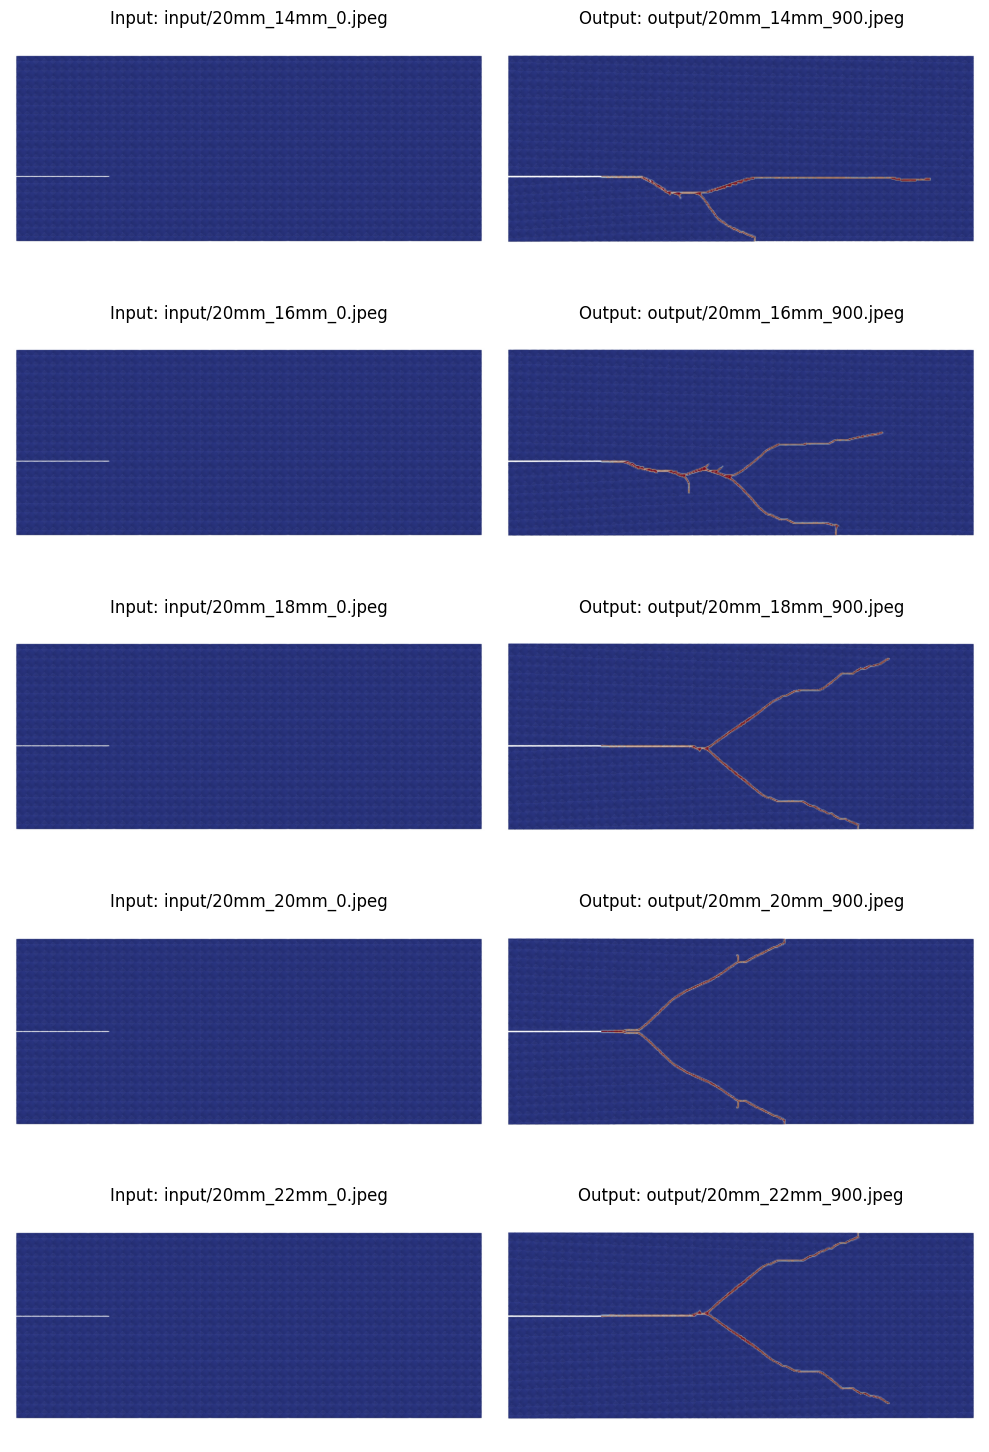

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

# Number of pairs to display
num_pairs = 5

# Plotting
plt.figure(figsize=(10, num_pairs * 3))

for i in range(num_pairs):
    row = df.iloc[i]
    input_img = Image.open(row['input_path'])
    output_img = Image.open(row['output_path'])
    
    # Input image
    plt.subplot(num_pairs, 2, 2 * i + 1)
    plt.imshow(input_img)
    plt.title(f"Input: {row['input_path']}")
    plt.axis('off')

    # Output image
    plt.subplot(num_pairs, 2, 2 * i + 2)
    plt.imshow(output_img)
    plt.title(f"Output: {row['output_path']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Material Properties
material_properties = {
    "density_rho": 2450,              # kg/m^3
    "youngs_modulus_E": 32e9,         # GPa to Pa
    "poissons_ratio_nu": 0.2,         
    "strain_max": 0.000509            # ε_max (unitless)
}

# Discretization Parameters
discretization = {
    "delta_p": 0.125e-3,              # mm to meters
    "h": 0.250e-3                     # mm to meters
}

# Artificial Viscosity
artificial_viscosity = {
    "beta1": 1.0,
    "beta2": 1.0
}

In [13]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

In [14]:
class CrackDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        input_img = Image.open(self.df.iloc[idx]['input_path']).convert('RGB')
        output_img = Image.open(self.df.iloc[idx]['output_path']).convert('RGB')

        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)

        return input_img, output_img


In [15]:
def physics_loss(pred, material_props, discretization):
    # Simple version: penalize high pixel intensity gradients (non-smooth crack)
    grad_x = torch.abs(pred[:, :, :, :-1] - pred[:, :, :, 1:])
    grad_y = torch.abs(pred[:, :, :-1, :] - pred[:, :, 1:, :])
    smoothness_penalty = grad_x.mean() + grad_y.mean()

    # More advanced: use strain energy density proxy
    E = material_props['youngs_modulus_E']
    strain_max = material_props['strain_max']
    delta_p = discretization['delta_p']
    h = discretization['h']

    # Simplified Griffith energy release rate
    G = (E * strain_max**2 * h) / 2
    energy_penalty = torch.clamp(pred.mean() - G, min=0)

    return smoothness_penalty + energy_penalty


In [16]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [17]:
transform = transforms.Compose([
    transforms.Resize((128, 256)),
    transforms.ToTensor()
])

dataset = CrackDataset(df, transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

model = SimpleUNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    model.train()
    total_loss = 0
    for inputs, targets in loader:
        preds = model(inputs)
        data_loss = criterion(preds, targets)
        phys_loss = physics_loss(preds, material_properties, discretization)
        loss = data_loss + 0.1 * phys_loss  # λ=0.1 for physics guidance

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 1.3846
Epoch 2, Loss: 1.3591
Epoch 3, Loss: 1.3389
Epoch 4, Loss: 1.2937
Epoch 5, Loss: 1.1806
Epoch 6, Loss: 1.0111
Epoch 7, Loss: 0.8038
Epoch 8, Loss: 0.5554
Epoch 9, Loss: 0.3680
Epoch 10, Loss: 0.2653
Epoch 11, Loss: 0.1913
Epoch 12, Loss: 0.1453
Epoch 13, Loss: 0.1181
Epoch 14, Loss: 0.1017
Epoch 15, Loss: 0.0919
Epoch 16, Loss: 0.0861
Epoch 17, Loss: 0.0823
Epoch 18, Loss: 0.0789
Epoch 19, Loss: 0.0756
Epoch 20, Loss: 0.0727


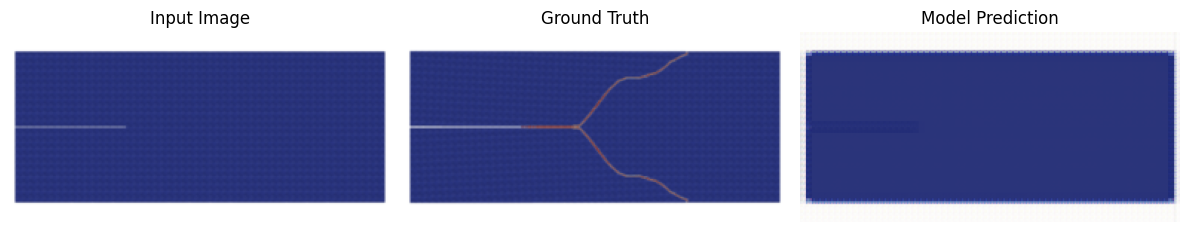

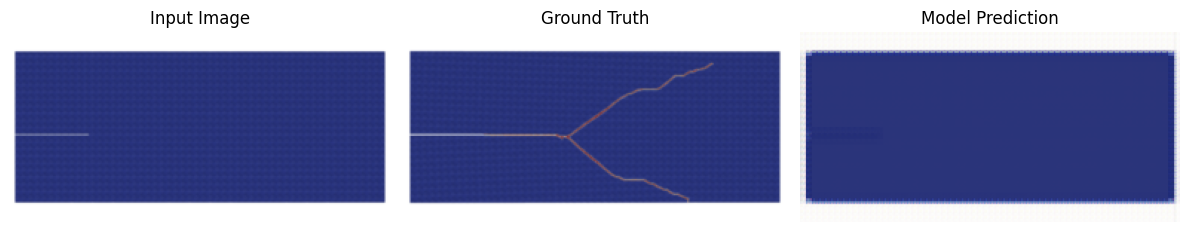

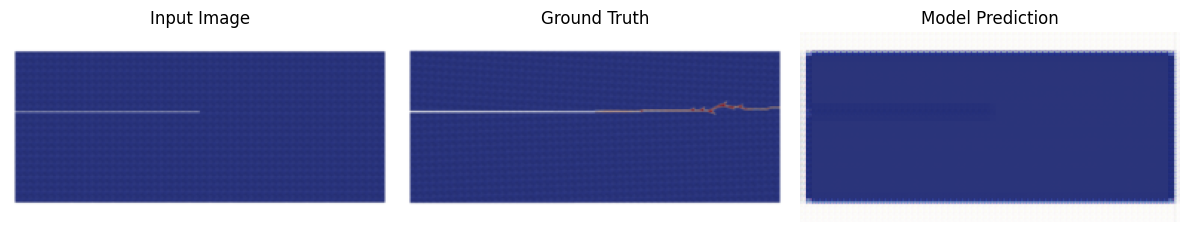

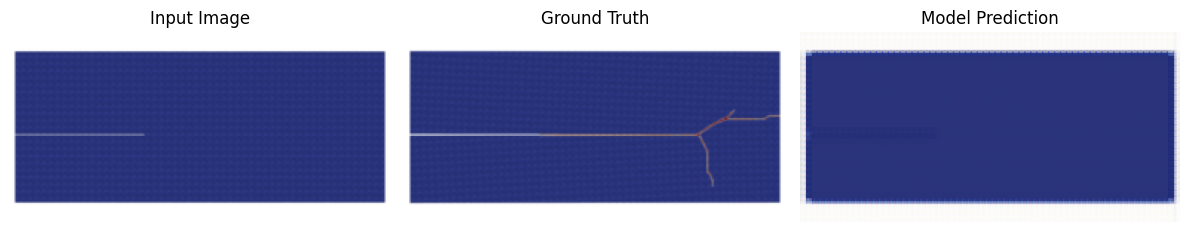

In [18]:
model.eval()  # Set to evaluation mode (important for things like dropout, batchnorm)

# Take a few samples from validation/test set
inputs, targets = next(iter(loader))  # Just take one batch
with torch.no_grad():
    preds = model(inputs)

# Convert tensors to NumPy images
def to_img(tensor):
    return tensor.permute(1, 2, 0).cpu().numpy()

for i in range(min(4, inputs.shape[0])):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(to_img(inputs[i]))
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(to_img(targets[i]))
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(to_img(preds[i]))
    plt.title("Model Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
